In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from tensorflow.keras import layers

In [2]:
# Preparing the data
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
df = pd.read_csv(file_url)

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [4]:
val_df = df.sample(frac=0.2, random_state=1337)
train_df = df.drop(val_df.index)
print(
"Using %d sample for training and %d for validation"
%(len(train_df), len(val_df)))

Using 242 sample for training and 61 for validation


In [5]:
# generation dataset objects for each df:
def df_to_ds(df):
    df_c = df.copy()
    labels = df.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    ds = ds.shuffle(buffer_size=len(df))
    return ds


train_ds = df_to_ds(train_df)
val_ds = df_to_ds(val_df)

In [6]:
for x,y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)
    

Input: {'age': <tf.Tensor: shape=(), dtype=int64, numpy=34>, 'sex': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'cp': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=118>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=182>, 'fbs': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'restecg': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=174>, 'exang': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>, 'slope': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'ca': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'thal': <tf.Tensor: shape=(), dtype=string, numpy=b'normal'>}
Target: tf.Tensor(0, shape=(), dtype=int64)


In [7]:
# bach the datasets:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

## Feature preprocessing with Keras layers

In [8]:
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
from tensorflow.keras.layers.experimental.preprocessing import StringLookup


In [9]:
def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_string_categorical_feature(feature, name, dataset):
    # Create a StringLookup layer which will turn strings into integer indices
    index = StringLookup()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    index.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = index(feature)

    # Create a CategoryEncoding for our integer indices
    encoder = CategoryEncoding(output_mode="binary")

    # Prepare a dataset of indices
    feature_ds = feature_ds.map(index)

    # Learn the space of possible indices
    encoder.adapt(feature_ds)

    # Apply one-hot encoding to our indices
    encoded_feature = encoder(encoded_feature)
    return encoded_feature


def encode_integer_categorical_feature(feature, name, dataset):
    # Create a CategoryEncoding for our integer indices
    encoder = CategoryEncoding(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the space of possible indices
    encoder.adapt(feature_ds)

    # Apply one-hot encoding to our indices
    encoded_feature = encoder(feature)
    return encoded_feature

## Build a model 

In [10]:
# Categorical features encoded as integers
sex = keras.Input(shape=(1,), name="sex", dtype="int64")
cp = keras.Input(shape=(1,), name="cp", dtype="int64")
fbs = keras.Input(shape=(1,), name="fbs", dtype="int64")
restecg = keras.Input(shape=(1,), name="restecg", dtype="int64")
exang = keras.Input(shape=(1,), name="exang", dtype="int64")
ca = keras.Input(shape=(1,), name="ca", dtype="int64")

# Categorical feature encoded as string
thal = keras.Input(shape=(1,), name="thal", dtype="string")

# Numerical features
age = keras.Input(shape=(1,), name="age")
trestbps = keras.Input(shape=(1,), name="trestbps")
chol = keras.Input(shape=(1,), name="chol")
thalach = keras.Input(shape=(1,), name="thalach")
oldpeak = keras.Input(shape=(1,), name="oldpeak")
slope = keras.Input(shape=(1,), name="slope")

all_inputs = [
    sex,
    cp,
    fbs,
    restecg,
    exang,
    ca,
    thal,
    age,
    trestbps,
    chol,
    thalach,
    oldpeak,
    slope,
]

# Integer categorical features
sex_encoded = encode_integer_categorical_feature(sex, "sex", train_ds)
cp_encoded = encode_integer_categorical_feature(cp, "cp", train_ds)
fbs_encoded = encode_integer_categorical_feature(fbs, "fbs", train_ds)
restecg_encoded = encode_integer_categorical_feature(restecg, "restecg", train_ds)
exang_encoded = encode_integer_categorical_feature(exang, "exang", train_ds)
ca_encoded = encode_integer_categorical_feature(ca, "ca", train_ds)

# String categorical features
thal_encoded = encode_string_categorical_feature(thal, "thal", train_ds)

# Numerical features
age_encoded = encode_numerical_feature(age, "age", train_ds)
trestbps_encoded = encode_numerical_feature(trestbps, "trestbps", train_ds)
chol_encoded = encode_numerical_feature(chol, "chol", train_ds)
thalach_encoded = encode_numerical_feature(thalach, "thalach", train_ds)
oldpeak_encoded = encode_numerical_feature(oldpeak, "oldpeak", train_ds)
slope_encoded = encode_numerical_feature(slope, "slope", train_ds)

all_features = layers.concatenate(
    [
        sex_encoded,
        cp_encoded,
        fbs_encoded,
        restecg_encoded,
        exang_encoded,
        slope_encoded,
        ca_encoded,
        thal_encoded,
        age_encoded,
        trestbps_encoded,
        chol_encoded,
        thalach_encoded,
        oldpeak_encoded,
    ]
)
x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

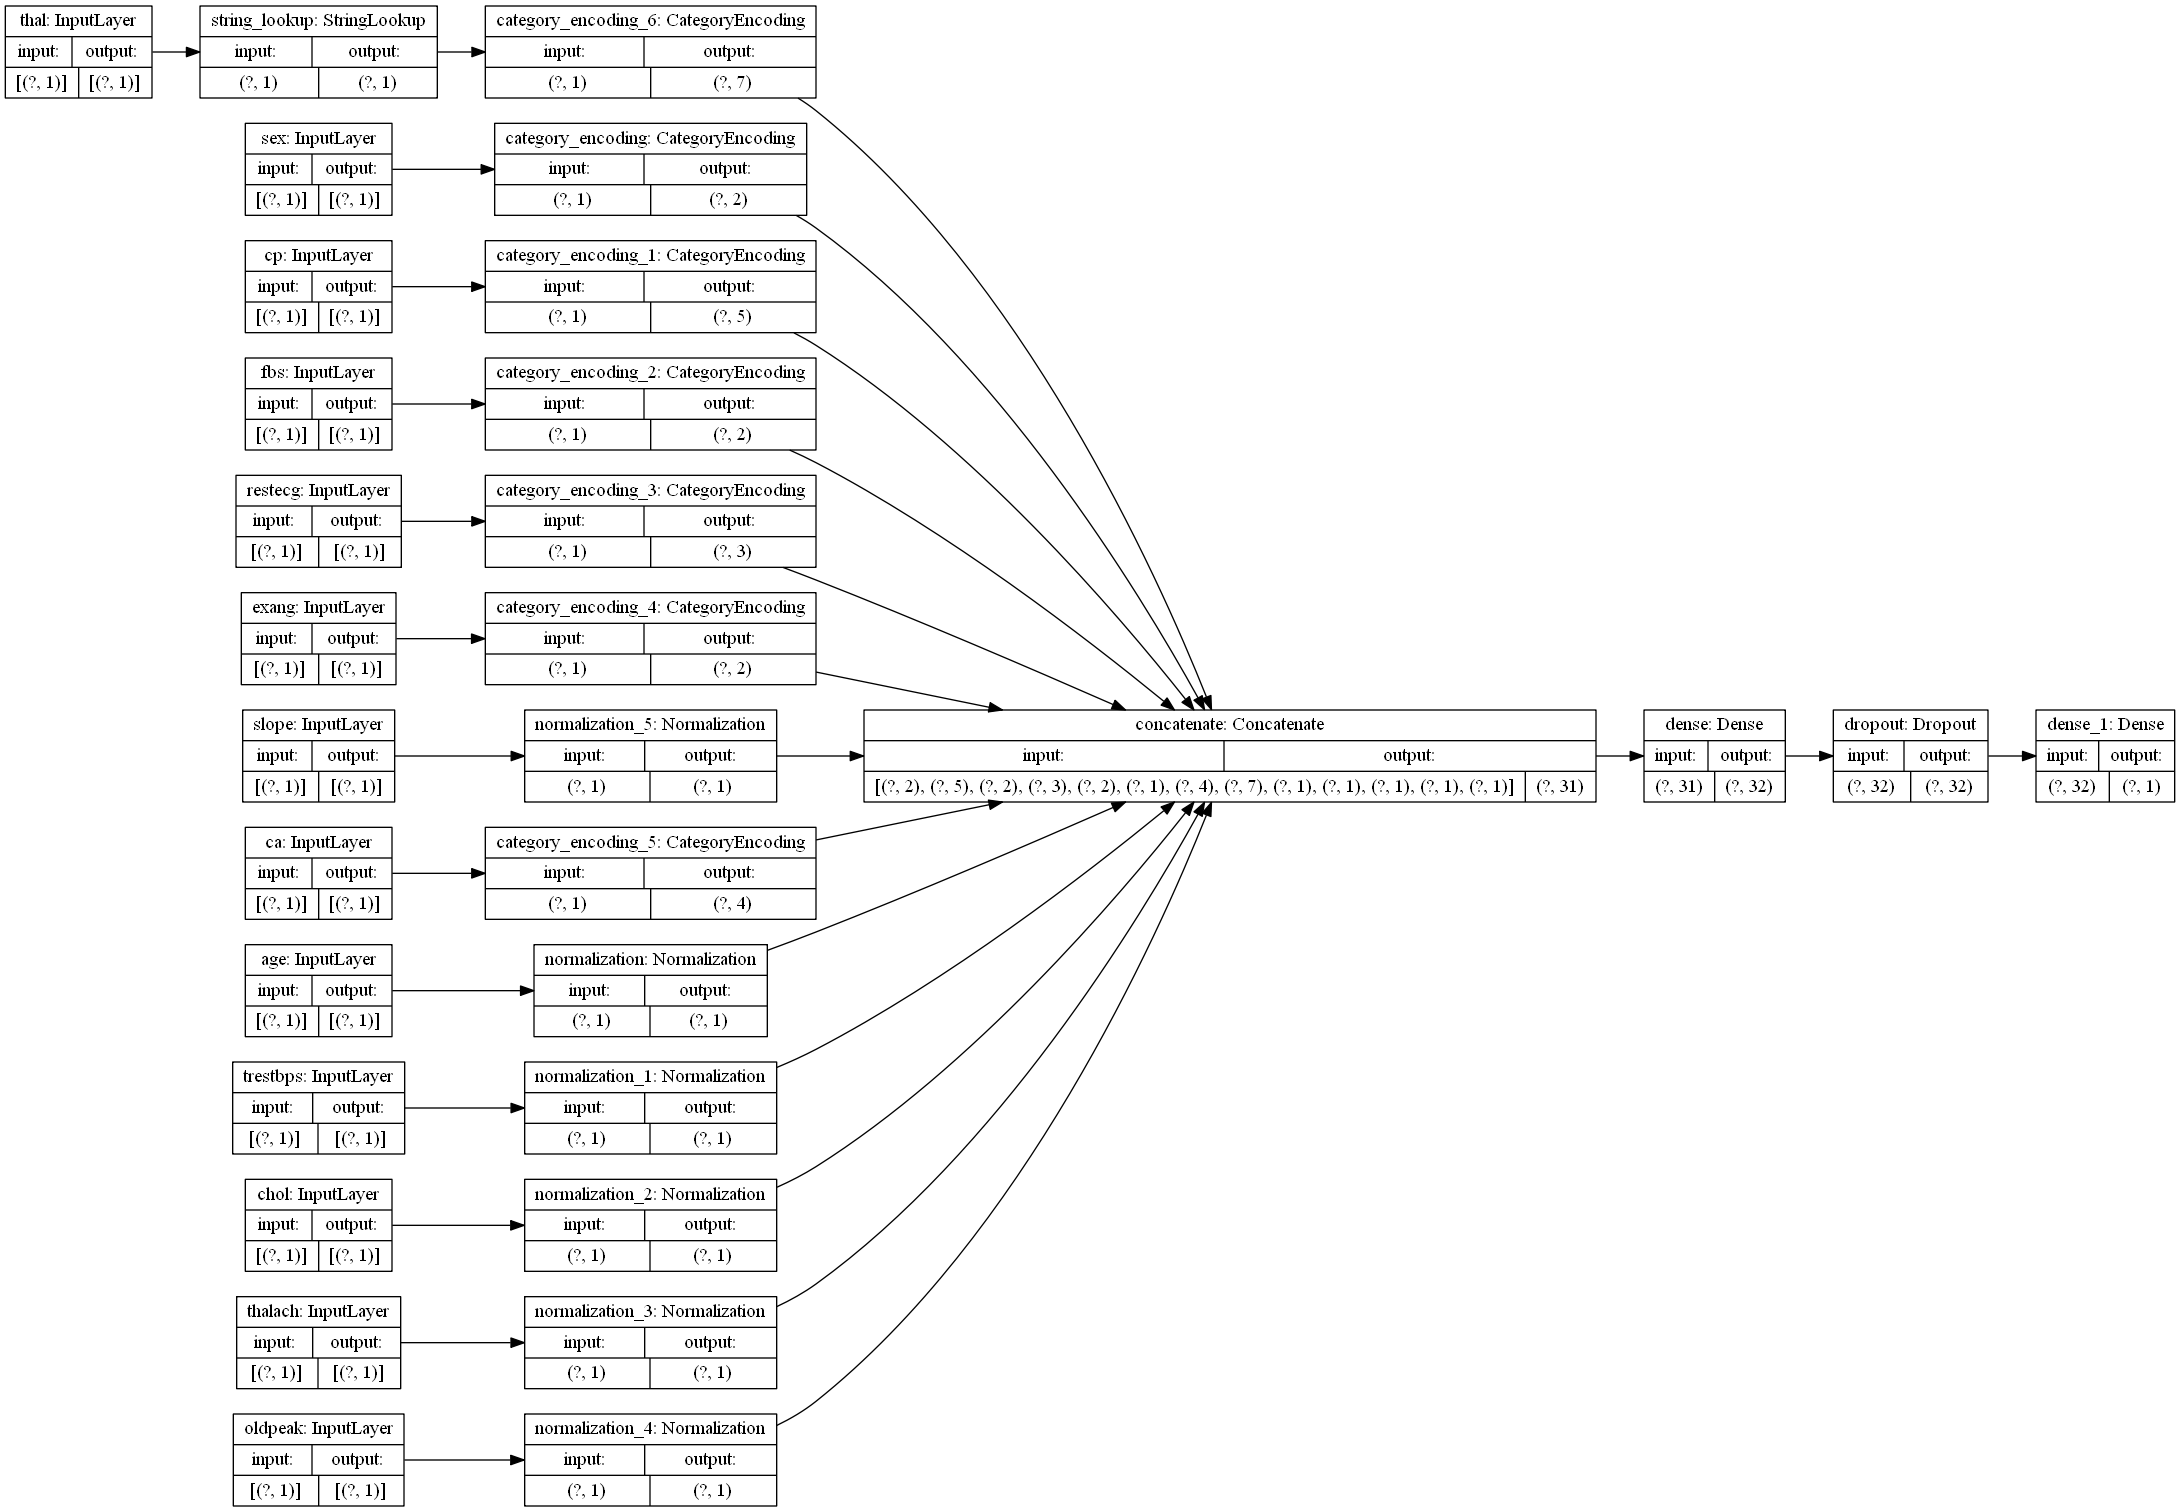

In [11]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

## Train the model 

In [12]:
model.fit(train_ds, epochs=50, validation_data=val_ds)


Epoch 1/50
8/8 [==============================] - 1s 75ms/step - loss: 0.8767 - accuracy: 0.3926 - val_loss: 0.7965 - val_accuracy: 0.3443
Epoch 2/50
8/8 [==============================] - 0s 5ms/step - loss: 0.8151 - accuracy: 0.4793 - val_loss: 0.7176 - val_accuracy: 0.5082
Epoch 3/50
8/8 [==============================] - 0s 6ms/step - loss: 0.6867 - accuracy: 0.5702 - val_loss: 0.6543 - val_accuracy: 0.6230
Epoch 4/50
8/8 [==============================] - 0s 4ms/step - loss: 0.6682 - accuracy: 0.5785 - val_loss: 0.6048 - val_accuracy: 0.6885
Epoch 5/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5997 - accuracy: 0.6942 - val_loss: 0.5647 - val_accuracy: 0.7377
Epoch 6/50
8/8 [==============================] - 0s 5ms/step - loss: 0.5942 - accuracy: 0.7149 - val_loss: 0.5333 - val_accuracy: 0.7541
Epoch 7/50
8/8 [==============================] - 0s 5ms/step - loss: 0.5505 - accuracy: 0.7479 - val_loss: 0.5051 - val_accuracy: 0.7541
Epoch 8/50
8/8 [=================

## Inference on new data

In [16]:
sample = {
    "age": 60,
    "sex": 1,
    "cp": 1,
    "trestbps": 145,
    "chol": 233,
    "fbs": 1,
    "restecg": 2,
    "thalach": 150,
    "exang": 0,
    "oldpeak": 2.3,
    "slope": 3,
    "ca": 0,
    "thal": "fixed",
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(
    "This particular patient had a %.1f percent probability "
    "of having a heart disease, as evaluated by our model." % (100 * predictions[0][0],)
)

This particular patient had a 16.2 percent probability of having a heart disease, as evaluated by our model.
